In [37]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.contrib import itertools

In [38]:
task_count = 50
learner_count = 10000

In [39]:
def rgbeta(n: int, mean: float, var: float, min: float = 0, max: float = 1) -> float:
    dmin = mean - min
    dmax = max - mean

    if dmin <= 0 or dmax <= 0:
        raise ValueError(f"mean must be between min = {min} and max = {max}")

    if var >= dmin * dmax:
        raise ValueError(
            f"var must be less than (mean - min) * (max - mean) = {dmin * dmax}")

    mx = (mean - min) / (max - min)
    vx = var / (max - min) ** 2

    a = ((1 - mx) / vx - 1 / mx) * mx ** 2
    b = a * (1 / mx - 1)

    x = np.random.beta(a, b, n)
    y = (max - min) * x + min

    return y.tolist()


In [40]:
def calc_complexity(frequency, regulation=0.5, weight=1):
    return ((frequency*weight)**(1/regulation))/(1+((frequency*weight)**(1/regulation))) 

def calc_frequency(complexity, regulation=0.5, weight=1):
    x = -complexity/(1-complexity)
    if(x<0): x = x*-1
    return x**regulation

In [41]:
def create_random_task(dql_model: dict[str, list[str]]):
    return {key: [random.randint(0, 7) for _ in dql_model[key]] for key in dql_model}


def create_optimal_task(dql_model: dict[str, list[str]], learner_competency: dict[str, list[float]], scaffolding_bonus: dict[str, list[float]]):
    return {key: [np.clip(calc_frequency(learner_competency[key][i] + scaffolding_bonus[key][i]), 0, 7) for i in range(len(dql_model[key]))] for key in dql_model}

In [42]:
def calc_task_complexities(task: dict[str, list[int]]):
    return {key: calc_complexity_for_category(category) for key, category in task.items()}


def calc_complexity_for_category(category: list[int]):
    return list(calc_complexity(frequency, regulation=0.5, weight=1) for frequency in category)

In [43]:
def create_learner_scaffolded_competence_bonuses(dql_model: dict[str, list[str]]):
    return {key: rgbeta(len(dql_model[key]), 0.1, 0.002, 0, 1) for key in dql_model}


def sample_from_snd_vectorized_and_normalize(X: list[float], mean=0, sd=1):
    # Generate random normal samples and normalize using min-max
    samples = np.random.normal(mean, sd, len(X))
    min_x = min(samples)
    max_x = max(samples)
    return ((samples - min_x) / (max_x - min_x)).tolist()


def create_learner_competencies(dql_model: dict[str, list[str]]):
    return {key: sample_from_snd_vectorized_and_normalize(dql_model[key]) for key in dql_model}


def create_learner_population(learner_count: int, task_count: int, dql_model: dict[str, list[str]]):
    return {
        "learner_competencies": [create_learner_competencies(dql_model) for _ in range(learner_count)],
        "scaffolding_competence_bonus_per_step_and_learner": [[create_learner_scaffolded_competence_bonuses(dql_model) for _ in range(learner_count)] for _ in range(task_count)]
    }

In [44]:
def create_learner_population(learner_count: int, task_count: int, dql_model: dict[str, list[str]]):
    return {
        "learner_competencies": [create_learner_competencies(dql_model) for _ in range(learner_count)],
        "scaffolding_competence_bonus_per_step_and_learner": [[create_learner_scaffolded_competence_bonuses(dql_model) for _ in range(learner_count)] for _ in range(task_count)]
    }


def calculate_delta(learner_competency: dict[str, list[str]], task_complexities: dict[str, list[str]], scaffolding_bonus: dict[str, list[str]]):
    result = {}
    for key in learner_competency:
        result[key] = []
        for i in range(len(learner_competency[key])):
            k = learner_competency[key][i]
            c = task_complexities[key][i]
            t = scaffolding_bonus[key][i]
            if (c <= k or c > k + t):
                result[key].append(0)
            else:
                result[key].append(c - k)
    return result


def add_delta_to_competency(competency: dict[str, list[str]], delta: dict[str, list[str]]):
    return {key: [competency[key][i] + delta[key][i] for i in range(len(competency[key]))] for key in competency}

In [45]:
def simulate_task_adaptation(task_count: int, learner_count: int, dql_model: dict[str, list[str]]):

    learner_population = create_learner_population(
        learner_count, task_count, dql_model)

    simulationLog = [{
        "tasks": [],
        "competencies": [],
        "scaffolding_bonuses": [],
        "deltas": []
    } for _ in range(learner_count)]

    for i, j in itertools.product(range(task_count), range(learner_count)):
        learner_competency = learner_population["learner_competencies"][j]
        scaffolding_bonus = learner_population["scaffolding_competence_bonus_per_step_and_learner"][i][j]

        # task = create_random_task(dql_model)
        task = create_optimal_task(
            dql_model, learner_competency, scaffolding_bonus)

        task_complexities = calc_task_complexities(task)
        delta = calculate_delta(
            learner_competency, task_complexities, scaffolding_bonus)

        # update the learner competency in the global learner population
        learner_population["learner_competencies"][j] = add_delta_to_competency(
            learner_competency, delta)

        simulationLog[j]["tasks"].append(task)
        simulationLog[j]["competencies"].append(learner_competency)
        simulationLog[j]["scaffolding_bonuses"].append(scaffolding_bonus)
        simulationLog[j]["deltas"].append(delta)

    return simulationLog

In [46]:
def plot_simulation_log(simulationLog: dict[str, list[list[float]]], dql_model: dict[str, list[str]], learnerId: int):
    plt.figure(figsize=(16, 9))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, key in enumerate(dql_model):
        color = colors[i % len(colors)]

        aggregated_competency_values = []
        aggregated_task_values = []
        aggregated_competency_plus_bonus_values = []
        for i in range(task_count):
            # Get competency value
            competency_values = simulationLog[learnerId]["competencies"][i][key]
            competency_aggregated = sum(
                competency_values)/len(competency_values)
            aggregated_competency_values.append(competency_aggregated)

            # Get task complexity value
            task_values = calc_task_complexities(
                simulationLog[learnerId]["tasks"][i])[key]
            task_aggregated = sum(task_values)/len(task_values)
            aggregated_task_values.append(task_aggregated)

            scaffolding_bonus_values = simulationLog[learnerId]["scaffolding_bonuses"][i][key]
            # Add the scaffolding bonus to the competency value
            competency_plus_bonus_values = [
                a + b for a, b in zip(scaffolding_bonus_values, competency_values)]
            competency_plus_bonus_aggregated = sum(
                competency_plus_bonus_values)/len(competency_plus_bonus_values)
            aggregated_competency_plus_bonus_values.append(
                competency_plus_bonus_aggregated)

        plt.plot(range(task_count), aggregated_competency_values,
                 color=color, label=f'{key} competency')
        plt.plot(range(task_count), aggregated_task_values,
                 '.', color=color, label=f'{key} task')
        plt.plot(range(task_count), aggregated_competency_plus_bonus_values,
                 '--', color=color, label=f'{key} competency + scaffolding bonus')

    plt.ylim(0, 1)
    plt.xlim(0, task_count-1)
    plt.ylabel("Competency")
    plt.xlabel("Step")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(
        f"sql_task_adaptation_{learnerId}.png", dpi=300, bbox_inches="tight")

In [47]:
dql_model = {
    "join": ["inner_join", "outer_join", "self_join"],
    "nesting": ["cte", "correlated_subquery", "uncorrelated_subquery"],
    "predicates": ["basic_operators", "logical_operators", "set_operators"]
}


simulationLog = simulate_task_adaptation(
    task_count, learner_count, dql_model)

  0%|          | 0/500000 [00:00<?, ?it/s]

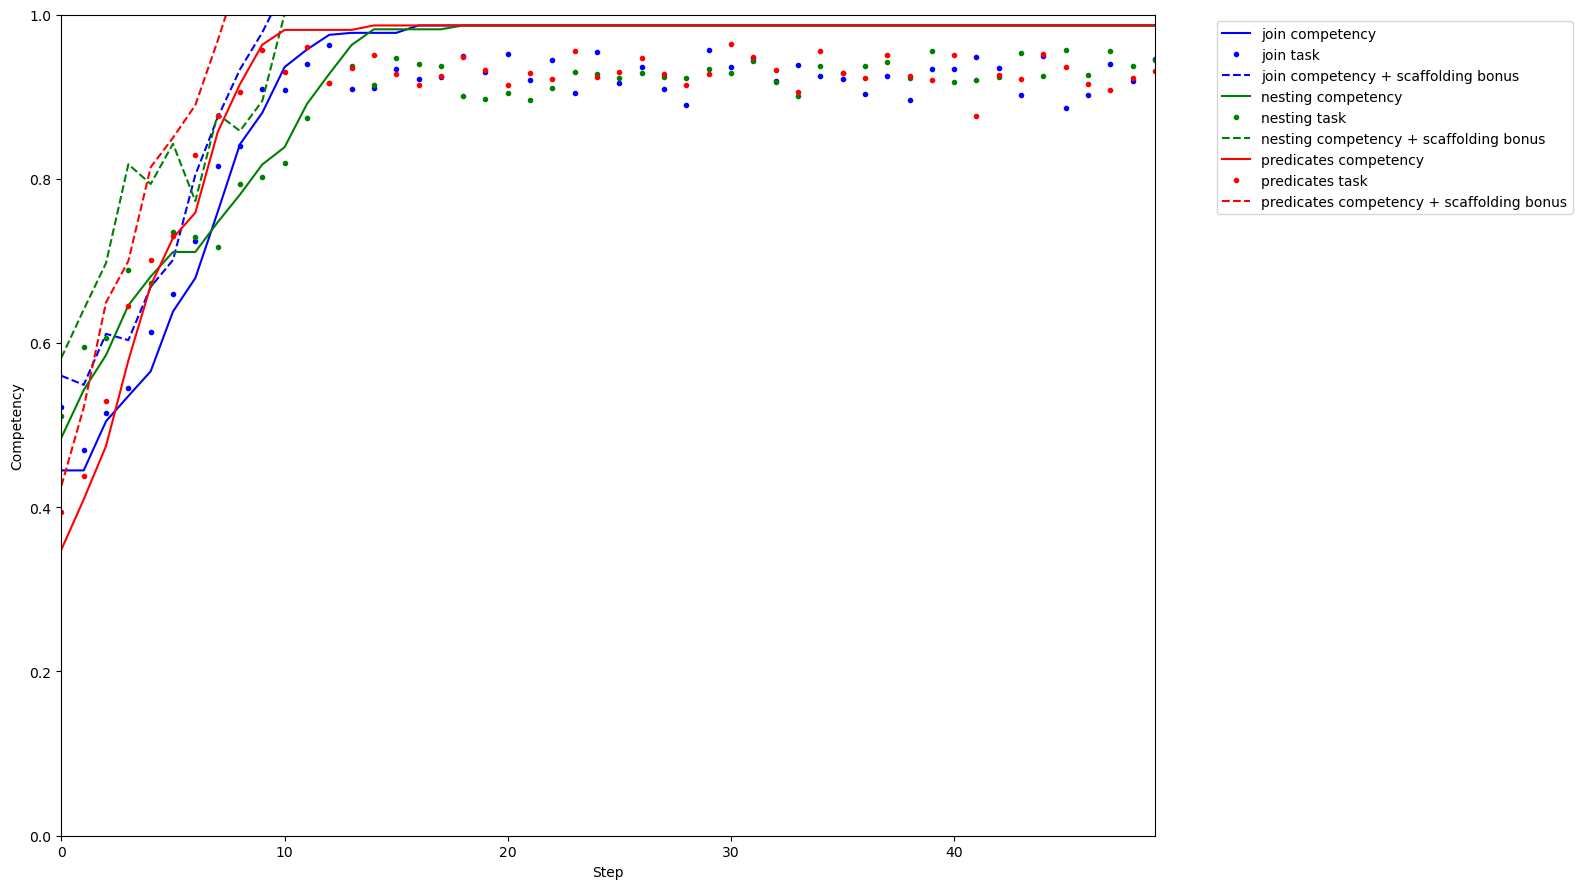

In [48]:
plot_simulation_log(simulationLog, dql_model, 0)

In [51]:
import pandas as pd

records = []
order_id = 0

# Iterate through each student 
for studentId, taskIndex in itertools.product(range(len(simulationLog)), range(task_count)):
    task_order_id = order_id  # Create one order_id per task
    # Iterate through categories
    for category_i, (category_name, category_elements) in enumerate(dql_model.items()):
        # Iterate through elements in category
        for element_i, element in enumerate(category_elements):
            # Get delta for this element
            delta = simulationLog[studentId]["deltas"][taskIndex][category_name][element_i]
            
            # Create record with zero-padded IDs
            # Calculate position: (category_i * elements_per_category) + element_i
            skill_position = (category_i * len(category_elements)) + element_i
            record = {
                'order_id': f'{task_order_id+1:08d}',
                'user_id': f'{studentId+1:06d}',
                'sequence_id': f'{studentId+1:06d}',
                'skill_id': skill_position+1,
                'correct': 1 if delta > 0 else 0
            }
            records.append(record)
    order_id += 1  # Increment order_id only after all records for a task are created

# Create and save dataframe
df = pd.DataFrame(records)
df.to_csv('dataset.csv', index=False, sep=',')

  0%|          | 0/500000 [00:00<?, ?it/s]